In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
import os
import matplotlib.pyplot as plt
import numpy as np
import cv2
from PIL import Image
from glob import glob

In [17]:
def list_images(images, cols = 2, rows = 5, cmap=None):

    plt.figure(figsize=(10, 12))
    for i, image in enumerate(images):
        plt.subplot(rows, cols, i+1)

        cmap = 'gray' if len(image.shape) == 2 else cmap
        plt.imshow(image, cmap = cmap)
        plt.subplots_adjust(hspace=0.3, wspace=0.3)
    plt.show()

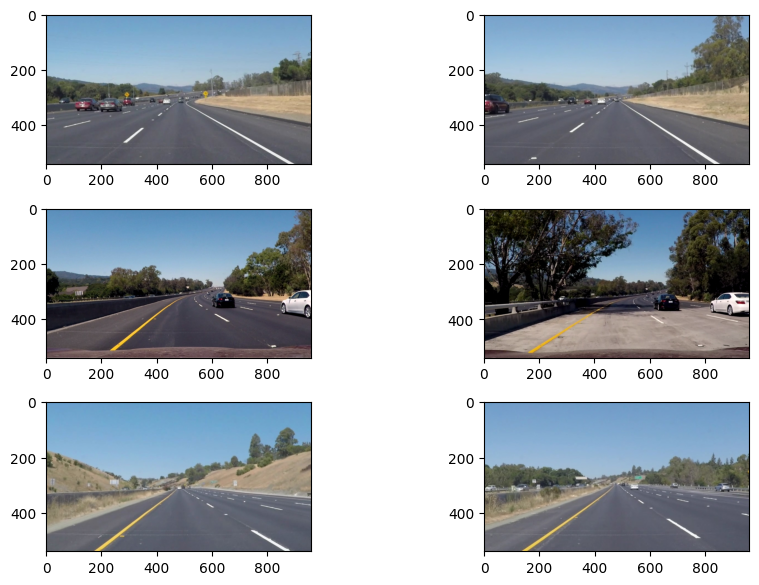

In [18]:
test_images = [plt.imread(img) for img in glob('/content/drive/MyDrive/LaneDetection/LaneDetection/Images/*.jpg')]
list_images(test_images)

In [19]:
def RGB_color_selection(image):

    lower_threshold = np.uint8([200, 200, 200])
    upper_threshold = np.uint8([255, 255, 255])
    white_mask = cv2.inRange(image, lower_threshold, upper_threshold)


    lower_threshold = np.uint8([175, 175,   0])
    upper_threshold = np.uint8([255, 255, 255])
    yellow_mask = cv2.inRange(image, lower_threshold, upper_threshold)

    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked_image = cv2.bitwise_and(image, image, mask = mask)

    return masked_image

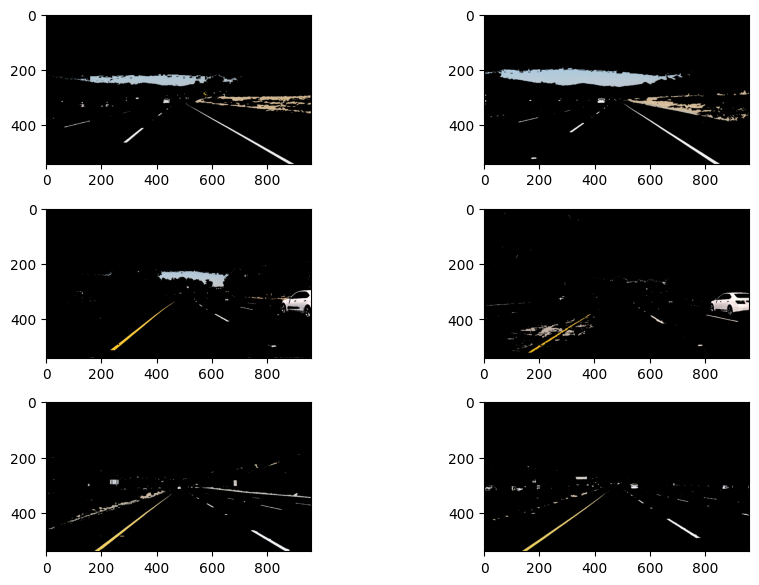

In [20]:
list_images(list(map(RGB_color_selection, test_images)))

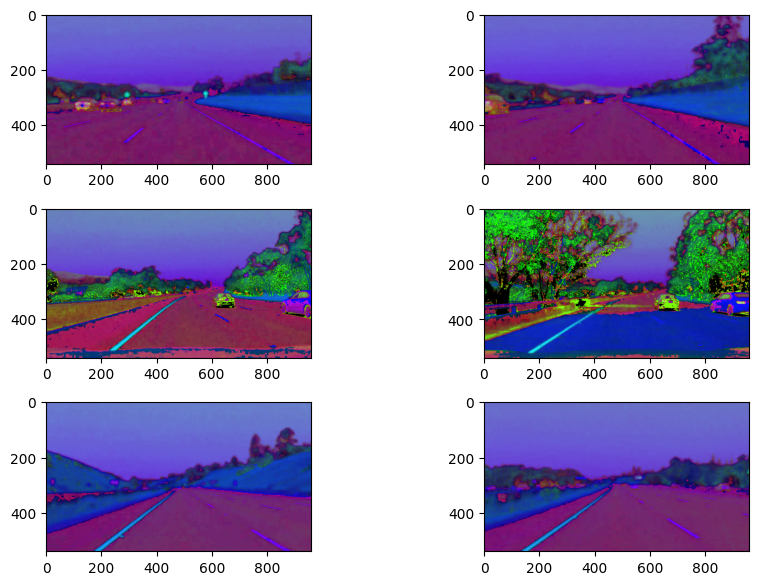

In [21]:
def convert_hsv(image):

    return cv2.cvtColor(image, cv2.COLOR_RGB2HSV)

list_images(list(map(convert_hsv, test_images)))

In [22]:
def HSV_color_selection(image):


    converted_image = convert_hsv(image)


    lower_threshold = np.uint8([0, 0, 210])
    upper_threshold = np.uint8([255, 30, 255])
    white_mask = cv2.inRange(converted_image, lower_threshold, upper_threshold)


    lower_threshold = np.uint8([18, 80, 80])
    upper_threshold = np.uint8([30, 255, 255])
    yellow_mask = cv2.inRange(converted_image, lower_threshold, upper_threshold)


    mask = cv2.bitwise_or(white_mask, yellow_mask)
    masked_image = cv2.bitwise_and(image, image, mask = mask)

    return masked_image

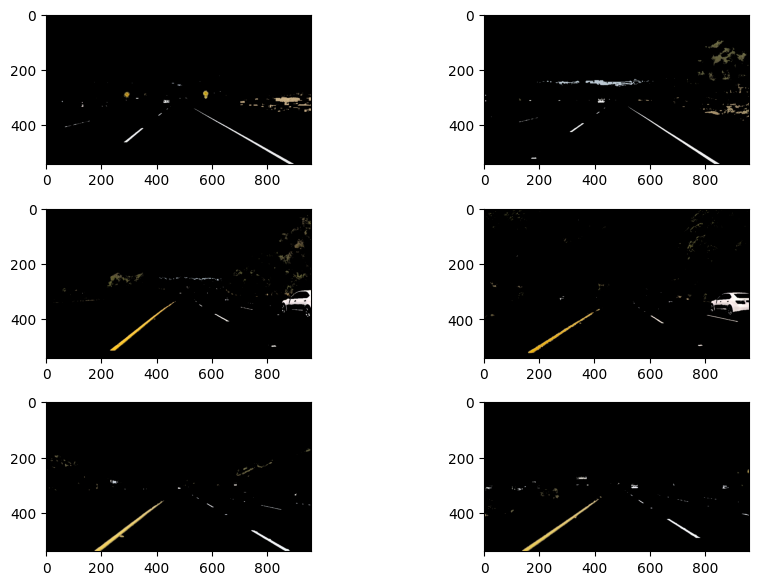

In [23]:
list_images(list(map(HSV_color_selection, test_images)))

In [24]:
def gray_scale(image):

    return cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)

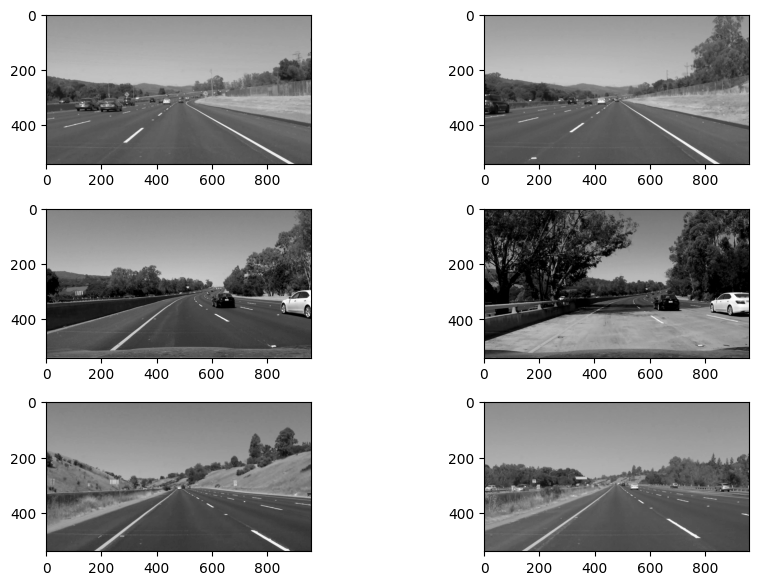

In [25]:
gray_images = list(map(gray_scale,test_images))
list_images(gray_images)

In [26]:
def gaussian_smoothing(image, kernel_size = 13):

    return cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

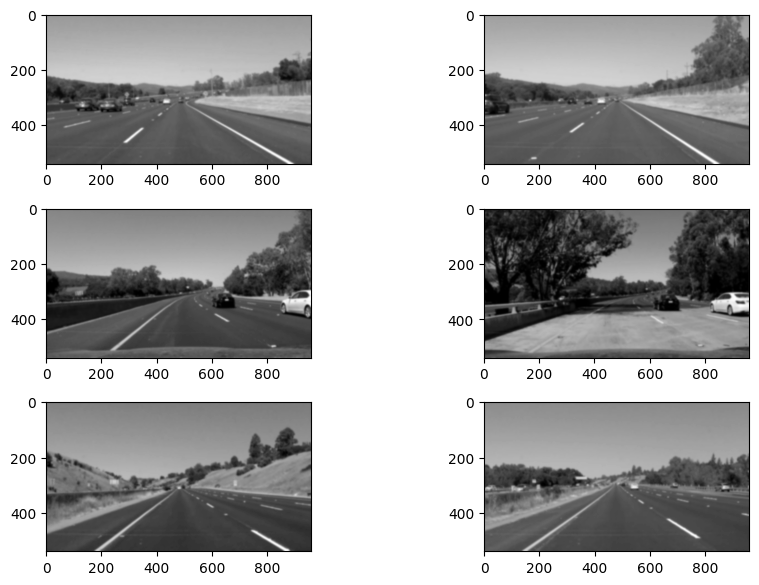

In [30]:
blur_images = list(map(gaussian_smoothing, gray_images))
list_images(blur_images)

In [31]:
def canny_detector(image, low_threshold = 50, high_threshold = 150):

    return cv2.Canny(image, low_threshold, high_threshold)

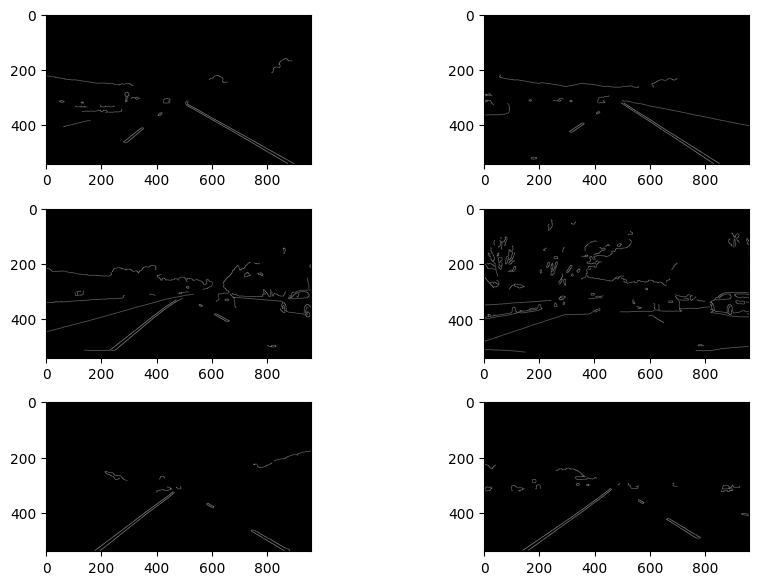

In [32]:
edge_detected_images = list(map(canny_detector, blur_images))
list_images(edge_detected_images)

In [33]:
def region_selection(image):

    mask = np.zeros_like(image)

    if len(image.shape) > 2:
        channel_count = image.shape[2]
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255

    rows, cols = image.shape[:2]
    bottom_left  = [cols * 0.1, rows * 0.95]
    top_left     = [cols * 0.4, rows * 0.6]
    bottom_right = [cols * 0.9, rows * 0.95]
    top_right    = [cols * 0.6, rows * 0.6]
    vertices = np.array([[bottom_left, top_left, top_right, bottom_right]], dtype=np.int32)
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    masked_image = cv2.bitwise_and(image, mask)
    return masked_image

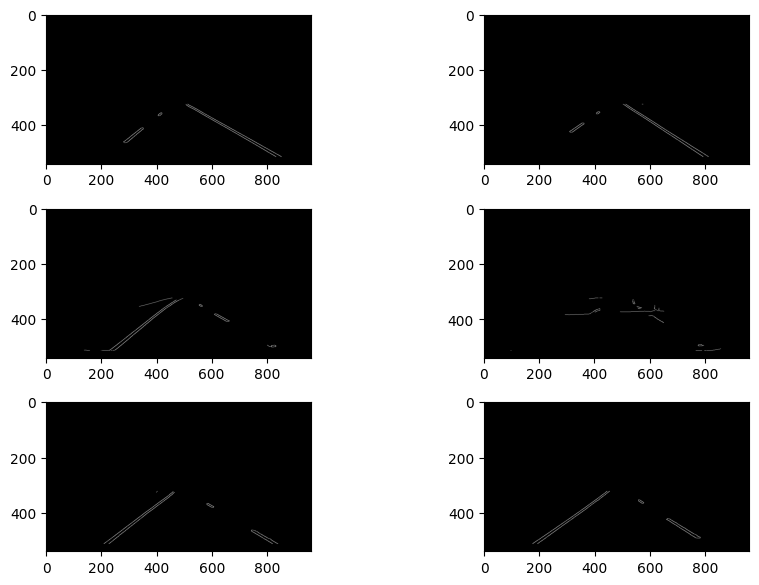

In [34]:
masked_image = list(map(region_selection, edge_detected_images))
list_images(masked_image)

In [35]:

def hough_transform(image):

    rho = 1
    theta = np.pi/180
    threshold = 20
    minLineLength = 20
    maxLineGap = 300
    return cv2.HoughLinesP(image, rho = rho, theta = theta, threshold = threshold,
                           minLineLength = minLineLength, maxLineGap = maxLineGap)

In [36]:
hough_lines = list(map(hough_transform, masked_image))

In [37]:
def draw_lines(image, lines, color = [0,0,255], thickness = 4):

    image = np.copy(image)
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(image, (x1, y1), (x2, y2), color, thickness)
    return image

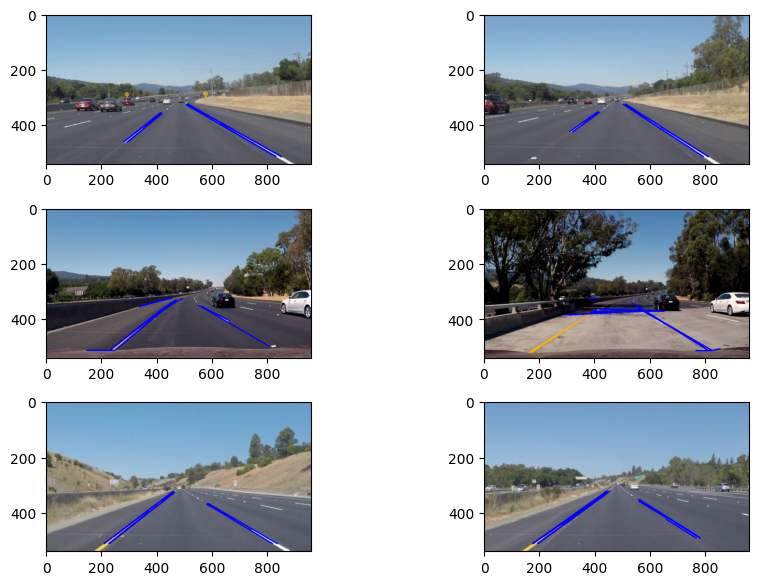

In [38]:
line_images = []
for image, lines in zip(test_images, hough_lines):
    line_images.append(draw_lines(image, lines))

list_images(line_images)

In [39]:
def average_slope_intercept(lines):

    left_lines    = []
    left_weights  = []
    right_lines   = []
    right_weights = []

    for line in lines:
        for x1, y1, x2, y2 in line:
            if x1 == x2:
                continue
            slope = (y2 - y1) / (x2 - x1)
            intercept = y1 - (slope * x1)
            length = np.sqrt(((y2 - y1) ** 2) + ((x2 - x1) ** 2))
            if slope < 0:
                left_lines.append((slope, intercept))
                left_weights.append((length))
            else:
                right_lines.append((slope, intercept))
                right_weights.append((length))
    left_lane  = np.dot(left_weights,  left_lines) / np.sum(left_weights)  if len(left_weights) > 0 else None
    right_lane = np.dot(right_weights, right_lines) / np.sum(right_weights) if len(right_weights) > 0 else None
    return left_lane, right_lane

In [40]:
def pixel_points(y1, y2, line):

    if line is None:
        return None
    slope, intercept = line
    x1 = int((y1 - intercept)/slope)
    x2 = int((y2 - intercept)/slope)
    y1 = int(y1)
    y2 = int(y2)
    return ((x1, y1), (x2, y2))

In [41]:
def lane_lines(image, lines):

    left_lane, right_lane = average_slope_intercept(lines)
    y1 = image.shape[0]
    y2 = y1 * 0.6
    left_line  = pixel_points(y1, y2, left_lane)
    right_line = pixel_points(y1, y2, right_lane)
    return left_line, right_line

In [42]:
def draw_lane_lines(image, lines, color=[255, 0, 0], thickness=12):

    line_image = np.zeros_like(image)
    for line in lines:
        if line is not None:
            cv2.line(line_image, *line,  color, thickness)
    return cv2.addWeighted(image, 1.0, line_image, 1.0, 0.0)


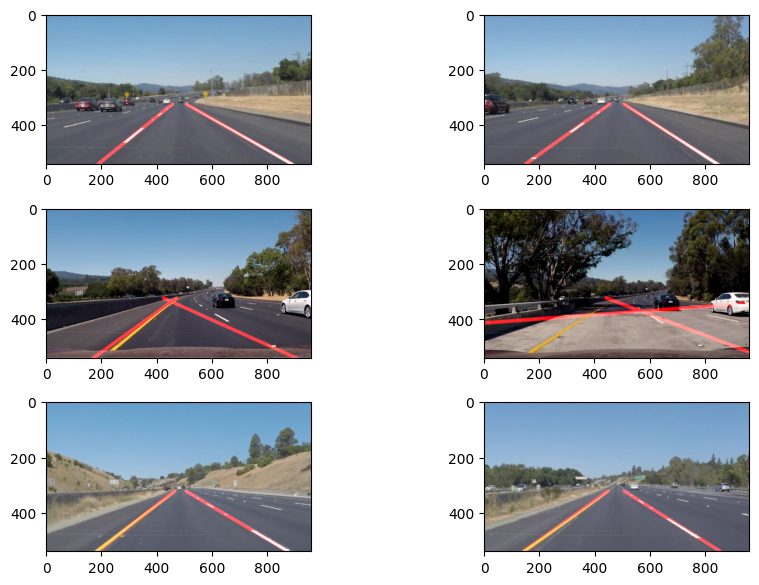

In [43]:
lane_images = []
for image, lines in zip(test_images, hough_lines):
    lane_images.append(draw_lane_lines(image, lane_lines(image, lines)))


list_images(lane_images)

In [44]:
from moviepy import *
from IPython.display import HTML
from IPython.display import Image

In [45]:
def frame_processor(image):
    """
    Process the input frame to detect lane lines.
        Parameters:
            image: Single video frame.
    """
    color_select = HSL_color_selection(image)
    gray         = gray_scale(color_select)
    smooth       = gaussian_smoothing(gray)
    edges        = canny_detector(smooth)
    region       = region_selection(edges)
    hough        = hough_transform(region)
    result       = draw_lane_lines(image, lane_lines(image, hough))
    return result

In [46]:
def process_video(test_video, output_video):
    """
    Read input video stream and produce a video file with detected lane lines.
        Parameters:
            test_video: Input video.
            output_video: A video file with detected lane lines.
    """
    input_video = VideoFileClip(os.path.join('test_videos', test_video), audio=False)
    processed = input_video.fl_image(frame_processor)
    processed.write_videofile(os.path.join('output_videos', output_video), audio=False)

In [47]:
%time process_video('solidWhiteRight.mp4', 'solidWhiteRight_output.mp4')
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("output_videos\solidWhiteRight_output.mp4"))

NameError: name 'VideoFileClip' is not defined

In [48]:
%time process_video('solidYellowLeft.mp4', 'solidYellowLeft_output.mp4')
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("output_videos\solidYellowLeft_output.mp4"))

NameError: name 'VideoFileClip' is not defined

In [49]:
%time process_video('challenge.mp4', 'challenge_output.mp4')
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("output_videos\challenge_output.mp4"))

NameError: name 'VideoFileClip' is not defined